# Memory Leak Detection

## What is memory leak ?
Memory leak is a condition that occurs when a developer creates an allocation of a memory but then does not deallocate it. The behaviour of memory usage varies from one programming language to another. In a few programming languages such as C or C++, as a developer we can dynamically allocate memory for our use. In another language such as Java, the operating system has the ability to allocate and deallocate memory automatically with the use of a garbage collector. Then why is it important for us to give attention to memory allocation? Careless memory allocation can cause memory leak which leads to decrease in performance allocation or even crash.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df_leak = pd.read_csv("sample-leak-1.csv")

df_leak.head()

,Unnamed: 0,time,percentage
0,2,20,6.2
1,4,21,6.4
2,6,22,6.8
3,8,23,7.2
4,9,24,7.2


In [15]:
df_no_leak = pd.read_csv("sample-no-leak-1.csv")

df_no_leak.head()

,Unnamed: 0,time,percentage
0,1,32,14.325
1,3,35,14.325
2,4,37,14.525
3,5,40,14.525
4,6,42,14.725


the data consist of two columns, 'time' represents the timestamp of a certain memory utilization and percentage represents the memory utilization percentage

In [4]:
len(df)

307

In [11]:
def plot_memory_graph(df):
    ax = plt.gca()
    ax.set_ylim([0, 100])
    ax.plot(df["time"], df["percentage"])

### Memory Leak Example

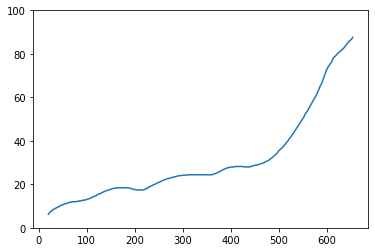

In [14]:
plot_memory_graph(df_leak)

we can see from the graph above that there is an indication of a memory leak from the steep and huge growth from 450th minute to 650th minute.

### No Memory Leak Example

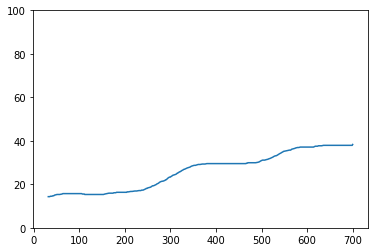

In [16]:
plot_memory_graph(df_no_leak)

this graph shows a relatively slow growth compared to the memory leak graph above

## Linear Backward Regression

In [6]:
from sklearn import linear_model
from sklearn.metrics import r2_score


In [7]:
def linear_backward_regression(df):
    anomaly = [0 for i in range(len(df))]
    
    window_size = 100
    critical_time = 100
    r_min = 0.8
    max_util = 100
    
    i = 2
    while i <= len(df) and i <= window_size:
        timestamps = df[-i:]
        
        model = linear_model.LinearRegression()
        model.fit(timestamps[["time"]], timestamps["percentage"])
        
        coef = model.coef_
        intercept = model.intercept_
        
        time_to_max_util = (max_util - intercept) / coef
        time_needed = time_to_max_util - df.loc[[len(df) - 1]]["time"].astype(float)
        
        predicted_value = model.predict(timestamps[["time"]])
        true_value = timestamps["percentage"]
        
        r2 = r2_score(true_value, predicted_value)
        
        r_valid = r2 >= r_min
        time_valid = time_needed <= critical_time
        
        if r_valid & time_valid.get(key=len(df) - 1):
            anomaly[-i:] = [1] * i
        
        i += 1
    
    return anomaly

- to improve the accuracy, we should include window_size, critical_time, max_util, r_min into hyperparameter tuning, but since we made this as a custom model, we should do the hyperparameter tuning manually by writing our code, not using the build in utility in sklearn library
- hyperparameter tuning also need a lot of data that has been labeled

In [20]:
anomaly_leak = linear_backward_regression(df_leak)

In [21]:
df_leak["anomaly"] = anomaly_leak
df_leak.head()

,Unnamed: 0,time,percentage,anomaly
0,2,20,6.2,0
1,4,21,6.4,0
2,6,22,6.8,0
3,8,23,7.2,0
4,9,24,7.2,0


In [22]:
df_leak.tail()

,Unnamed: 0,time,percentage,anomaly
302,315,650,86.4,1
303,318,651,86.6,1
304,320,652,86.8,1
305,325,653,87.2,1
306,331,654,87.6,1


anomaly column with value 0 represent no anomaly found and value 1 represent anomaly found

In [23]:
anomaly_no_leak = linear_backward_regression(df_no_leak)
df_no_leak["anomaly"] = anomaly_no_leak
df_no_leak.head()

,Unnamed: 0,time,percentage,anomaly
0,1,32,14.325,0
1,3,35,14.325,0
2,4,37,14.525,0
3,5,40,14.525,0
4,6,42,14.725,0


In [24]:
import matplotlib.pyplot as plt

def plot_memory_anomaly_graph(df):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2, right=0.85)

    newax = fig.add_axes(ax.get_position())
    newax.patch.set_visible(False)

    newax.yaxis.set_label_position('right')
    newax.yaxis.set_ticks_position('right')

    newax.spines['bottom'].set_position(('outward', 35))

    ax.plot(df["time"], df["percentage"], 'r-')
    ax.set_xlabel('Time', color='red')
    ax.set_ylabel('Percentage', color='red')
    ax.set_ylim([0, 100])

    newax.yaxis.set_visible(False)
    newax.xaxis.set_visible(False)

    newax.plot(df["time"], df["anomaly"], 'white')
    newax.fill_between(df["time"], df["anomaly"], 'green', alpha=0.5)

    plt.show()

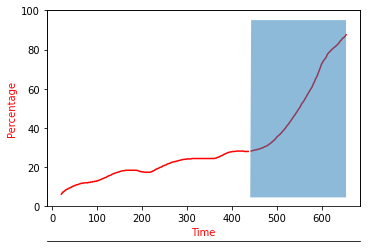

In [25]:
plot_memory_anomaly_graph(df_leak)

from the graph above, we can see that our model detected an anomaly or memory leak as we expected

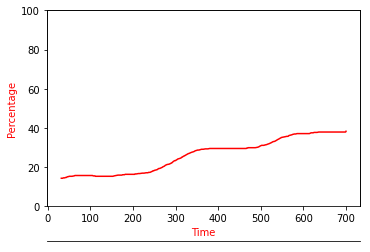

In [26]:
plot_memory_anomaly_graph(df_no_leak)

no anomaly or memory leak was detected, as humans we can agree that there is no memory leak here